In [1]:
library(data.table)
library(ggplot2)
library(ComplexUpset)
library(ComplexHeatmap)
library(repr)


Lade n"otiges Paket: grid

ComplexHeatmap version 2.15.4
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [2]:
library(extrafont)
font_import(paths = "/Library/Fonts", prompt = FALSE)
loadfonts()
fonts()


Registering fonts with R

Scanning ttf files in /Library/Fonts ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf
 : ArialUnicodeMS already registered in fonts database. Skipping.

/Library/Fonts/FontsFree-Net-MYRIADPRO-REGULAR.ttf
 : MyriadPro-Regular already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library/extrafontdb/metrics

Arial Unicode MS already registered with pdfFont().

Myriad Pro already registered with pdfFont().

Arial Unicode MS already registered with postscriptFont().

Myriad Pro already registered with postscriptFont().



[1] "Arial Unicode MS" "Myriad Pro"

## Upset plot for droplet classification of genetic deconvolution methods


### Define a function to convert the result to a binary matrix


In [3]:
convert2binary <- function(assignment, identity) {
  # table in a long format
  assignment_new <- melt(assignment, id.vars = 1)
  assignment_new <- na.omit(assignment_new)

  # Subset to identity
  assignment_new <-
    assignment_new[assignment_new$value == identity, ]
  assignment_new <- assignment_new[, -3]

  # table in a wide format
  assignment_new <- dcast(assignment_new, Barcode ~ variable)
  assignment_new <-
    as.data.frame(lapply(assignment_new[, -1], as.numeric))

  # turn into a binary matrix
  assignment_new[!is.na(assignment_new)] <- 1
  assignment_new[is.na(assignment_new)] <- 0

  return(assignment_new)
}


In [4]:
# Load genetic demultiplexing results
gene_gx12_classi <-
    fread("../data/pipeline_output/gx12/genetic_classification_all.csv")
head(gene_gx12_classi)
# Rename methods
colnames(gene_gx12_classi) <-
    c("Barcode", "Freemuxlet", "scSplit", "Souporcell", "Vireo")


Barcode,freemuxlet_1,scsplit_1,souporcell_1,vireo_1
<chr>,<chr>,<chr>,<chr>,<chr>
ACTTATCTCATGCCAA-1,singlet,doublet,singlet,singlet
GGGTCACAGCAGCAGT-1,singlet,singlet,singlet,singlet
CAGAGCCGTTGGGATG-1,singlet,singlet,singlet,singlet
GGTCACGTCGGTCTAA-1,singlet,singlet,singlet,singlet
GACATCACATCAGCGC-1,singlet,doublet,singlet,singlet
GCAACATGTACGGGAT-1,singlet,singlet,singlet,singlet


In [5]:
genetic_gx12_classi_new_singlet <- convert2binary(gene_gx12_classi, "singlet")
genetic_gx12_classi_new_doublet <- convert2binary(gene_gx12_classi, "doublet")


Using 'variable' as value column. Use 'value.var' to override



Using 'variable' as value column. Use 'value.var' to override



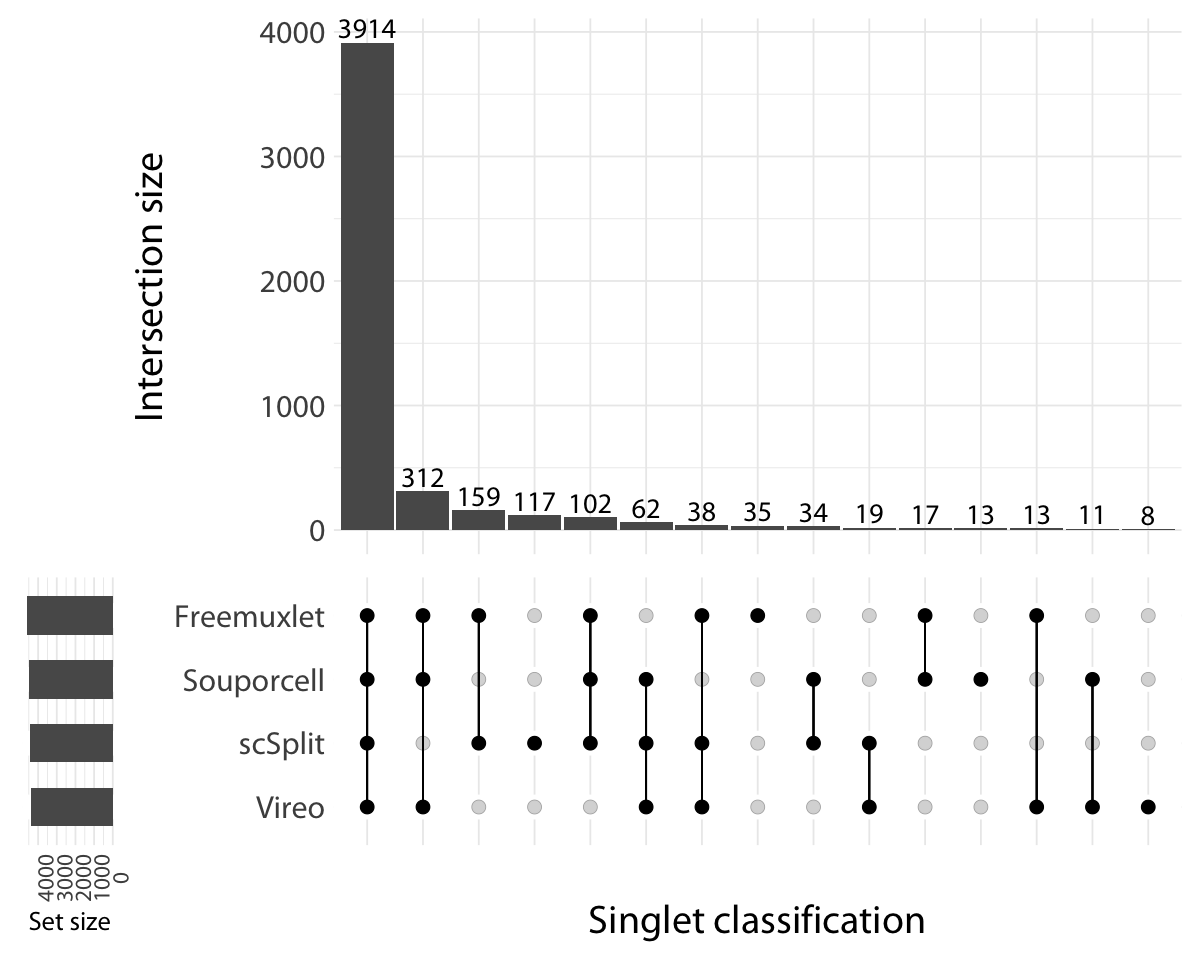

In [6]:
# Change plot size to 10 x 8
options(repr.plot.width = 10, repr.plot.height = 8)

ComplexUpset::upset(
    genetic_gx12_classi_new_singlet,
    colnames(genetic_gx12_classi_new_singlet),
    width_ratio = 0.1,
    height_ratio = 0.5,
    stripes = "white",
    min_degree = 1,
    name = "Singlet classification",
    set_sizes = (
        upset_set_size() + theme(
            axis.text.x = element_text(angle = 90, size = 14),
            axis.title.x = element_text(
                size =
                    16
            )
        )
    ),
    base_annotations = list(
        "Intersection size" = intersection_size(
            text = list(size = 6, family = "Myriad Pro"),
            width = 0.95,
            bar_number_threshold =
                1
        )
    ),
    themes = upset_default_themes(text = element_text(
        size = 24, family =
            "Myriad Pro"
    ))
)


# ggsave("s3/upset-genetic-singlet-gx12.pdf", dpi = 300, height = 8, width = 10)


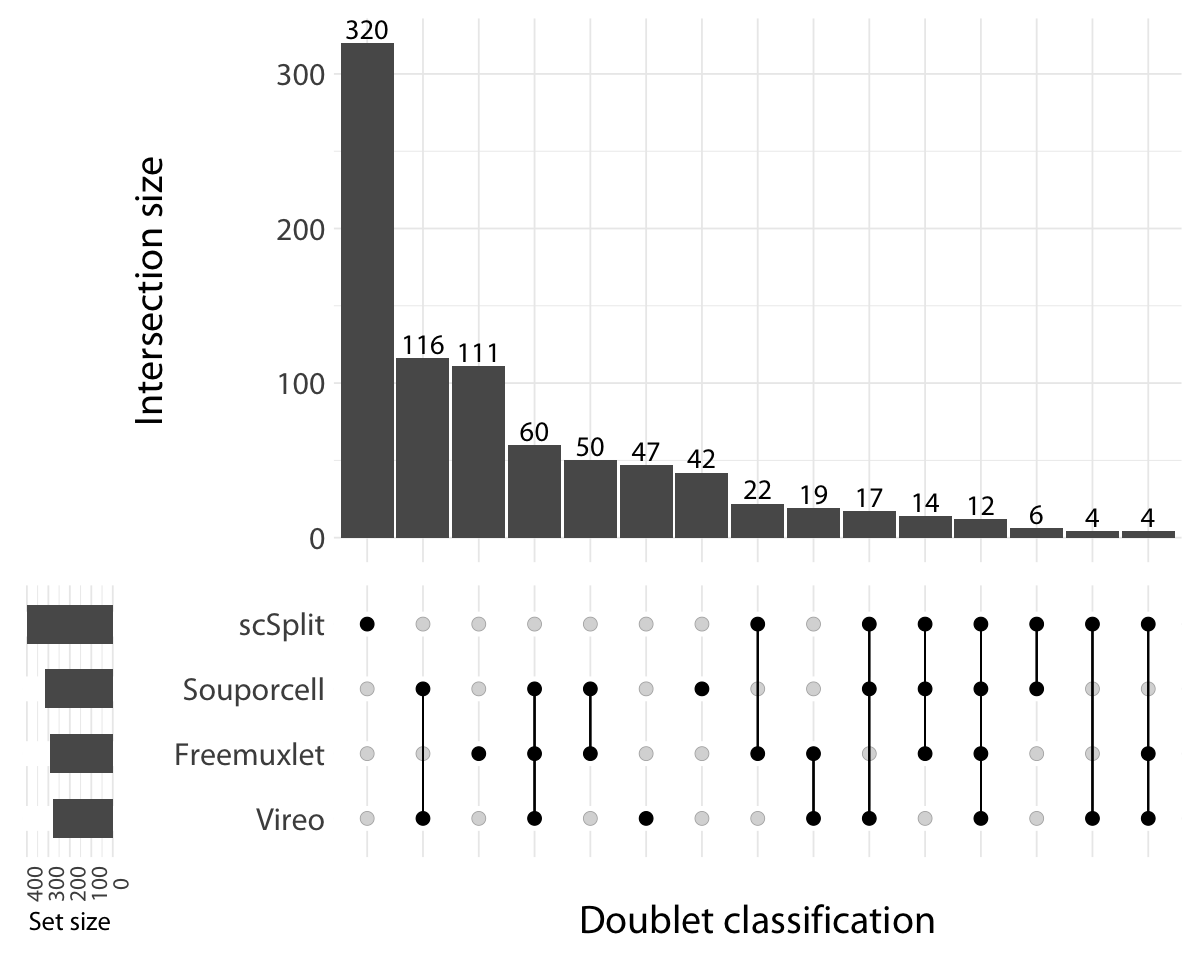

In [7]:
ComplexUpset::upset(
    genetic_gx12_classi_new_doublet,
    colnames(genetic_gx12_classi_new_singlet),
    width_ratio = 0.1,
    height_ratio = 0.5,
    stripes = "white",
    min_degree = 1,
    name = "Doublet classification",
    set_sizes = (
        upset_set_size() + theme(
            axis.text.x = element_text(angle = 90, size = 14),
            axis.title.x = element_text(
                size =
                    16
            )
        )
    ),
    base_annotations = list(
        "Intersection size" = intersection_size(
            text = list(size = 6, family = "Myriad Pro"),
            width = 0.95,
            bar_number_threshold =
                1
        )
    ),
    themes = upset_default_themes(text = element_text(
        size = 24, family =
            "Myriad Pro"
    ))
)

# ggsave("s3/upset-genetic-doublet-gx12.pdf", dpi = 300, height = 8, width = 10)


## Visualisation of concordance among genetic deconvolution methods through confusion matrix


In [8]:
# Load genetic demultiplexing results
gene_gx12_assign <-
    fread("../data/pipeline_output/gx12/genetic_assignment_all.csv")

# Remove the trial ID
colnames(gene_gx12_assign) <-
    c("Barcode", "Freemuxlet", "scSplit", "Souporcell", "Vireo")

# Remove the donor prefix in vireo column
gene_gx12_assign$Vireo <- gsub("donor", "", gene_gx12_assign$Vireo)


In [9]:
# Create an empyt matrix
confusion_matrix_f_so <- as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_f_so) <- 0:5
colnames(confusion_matrix_f_so) <- 0:5

# Fill the matrix
for (i in c(0:5)) {
  for (j in c(0:5)) {
    row <-
      nrow(gene_gx12_assign[gene_gx12_assign$Freemuxlet == i &
        gene_gx12_assign$Souporcell == j, ])
    confusion_matrix_f_so[i + 1, j + 1] <- row
  }
}

confusion_matrix_f_so


,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,0,646,1,0,0,0
1,756,0,0,1,0,0
2,1,0,697,0,0,1
3,0,1,0,223,1,0
4,0,0,0,0,0,795
5,0,0,0,1,1220,1


In [10]:
# Create an empyt matrix
confusion_matrix_v_so <- as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_so) <- 0:5
colnames(confusion_matrix_v_so) <- 0:5

# Fill the matrix
for (i in c(0:5)) {
  for (j in c(0:5)) {
    row <-
      nrow(gene_gx12_assign[gene_gx12_assign$Souporcell == i &
        gene_gx12_assign$Vireo == j, ])
    confusion_matrix_v_so[i + 1, j + 1] <- row
  }
}

rownames(confusion_matrix_v_so) <- paste0("Donor-", 0:5)
colnames(confusion_matrix_v_so) <- paste0("Donor-", 0:5)


In [11]:
cpalette <-
    circlize::colorRamp2(c(0, 400, 800, 1200), hcl.colors(5, "Blues 3", rev = T)[1:4])


Warning message:
"The input is a data frame-like object, convert it to a matrix."


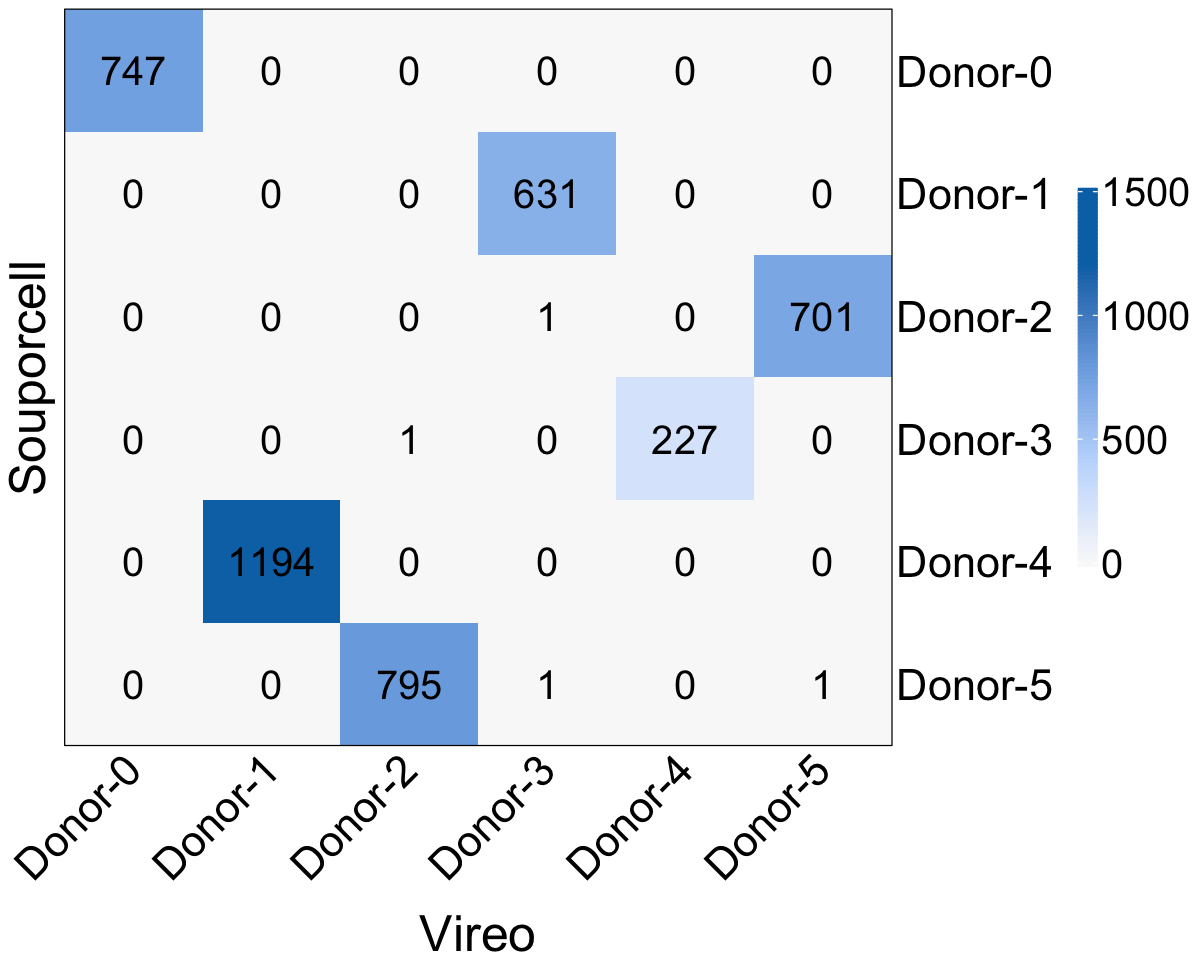

In [12]:
# pdf("s3/vireo_souporcell.pdf", family = "Myriad Pro", height = 8, width = 10)
Heatmap(
  confusion_matrix_v_so,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "Souporcell",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_so[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()


Warning message:
"The input is a data frame-like object, convert it to a matrix."


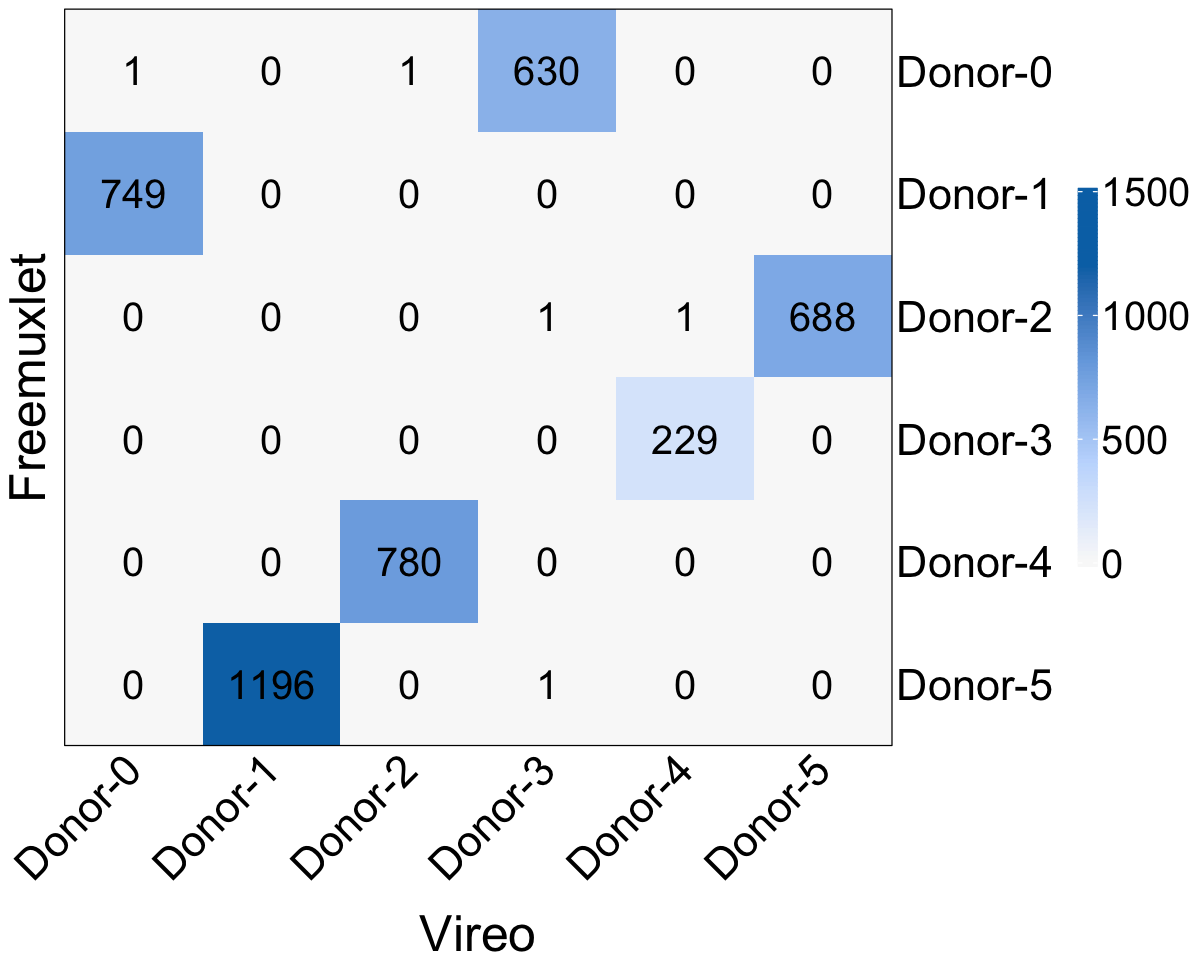

In [13]:
# Create an empyt matrix
confusion_matrix_v_fr <- as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_fr) <- 0:5
colnames(confusion_matrix_v_fr) <- 0:5

# Fill the matrix
for (i in c(0:5)) {
  for (j in c(0:5)) {
    row <-
      nrow(gene_gx12_assign[gene_gx12_assign$Freemuxlet == i &
        gene_gx12_assign$Vireo == j, ])
    confusion_matrix_v_fr[i + 1, j + 1] <- row
  }
}

rownames(confusion_matrix_v_fr) <- paste0("Donor-", 0:5)
colnames(confusion_matrix_v_fr) <- paste0("Donor-", 0:5)

# pdf(
#   "s3/vireo_freemuxlet.pdf",
#   family = "Myriad Pro",
#   height = 8,
#   width = 10
# )
Heatmap(
  confusion_matrix_v_fr,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "Freemuxlet",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_fr[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()


,Donor-0,Donor-1,Donor-2,Donor-3,Donor-4,Donor-5
,<int>,<int>,<int>,<int>,<int>,<int>
Donor-0,9,14,15,3,18,511
Donor-1,8,7,653,16,16,3
Donor-2,1,0,3,591,0,3
Donor-3,717,26,7,1,21,2
Donor-4,8,33,64,4,106,163
Donor-5,1,968,6,7,26,2


Warning message:
"The input is a data frame-like object, convert it to a matrix."


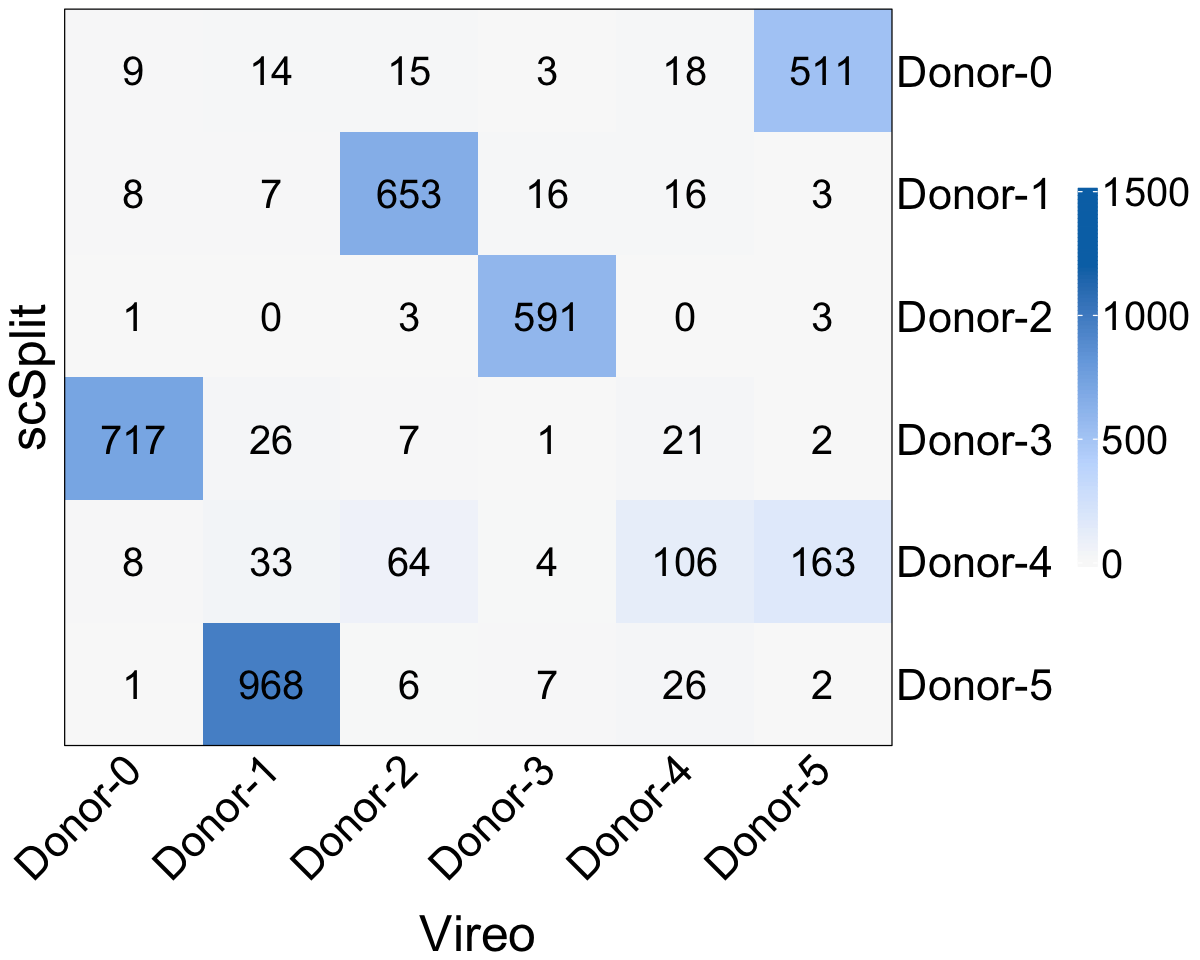

In [14]:
# Create an empyt matrix
confusion_matrix_v_sc <- as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_sc) <- 0:5

# scSplit assigned doublets to cluster 4
donor_list <- c(0:3, 5:6)
rownames(confusion_matrix_v_sc) <- donor_list

for (i in c(0:5)) {
  for (j in c(0:5)) {
    row <- nrow(gene_gx12_assign[gene_gx12_assign$Vireo == j &
      gene_gx12_assign$scSplit == donor_list[i + 1], ])
    confusion_matrix_v_sc[i + 1, j + 1] <- row
  }
}

rownames(confusion_matrix_v_sc) <- paste0("Donor-", 0:5)
colnames(confusion_matrix_v_sc) <- paste0("Donor-", 0:5)

confusion_matrix_v_sc
# pdf("s3/vireo_scsplit.pdf", family = "Myriad Pro", height = 8, width = 10)
Heatmap(
  confusion_matrix_v_sc,
  name = " ",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  row_title = "scSplit",
  column_title = "Vireo",
  column_title_side = "bottom",
  border = TRUE,
  column_title_gp = gpar(fontsize = 30),
  row_title_gp = gpar(fontsize = 30),
  row_names_gp = gpar(fontsize = 26),
  column_names_gp = gpar(fontsize = 26),
  column_names_rot = 45,
  col = cpalette,
  heatmap_legend_param = list(
    legend_height = unit(8, "cm"),
    labels_gp = gpar(fontsize = 24)
  ),
  cell_fun = function(j, i, x, y, w, h, col) {
    grid.text(round(confusion_matrix_v_sc[i, j], 2),
      x,
      y,
      gp = gpar(fontsize = 24, col = "black")
    )
  }
)
# dev.off()
